In [1]:
# Copyright (C) 2023 qBraid
# Copyright (C) IBM
#
# This file is part of the qBraid-SDK.
#
# The qBraid-SDK is free software released under the GNU General Public License v3
# or later. This specific file, adapted from Qiskit, is dual-licensed under both the
# Apache License, Version 2.0, and the GPL v3. You may not use this file except in
# compliance with the applicable license. You may obtain a copy of the Apache License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file includes code adapted from Qiskit (https://github.com/Qiskit/qiskit-ibm-provider)
# with modifications by qBraid. The original copyright notice is included above.
# THERE IS NO WARRANTY for the qBraid-SDK, as per Section 15 of the GPL v3.

# qBraid-SDK Braket on IonQ device Tutorial: Quantum Teleportation 

Per usual, install the qBraid SDK environment on Lab, and use the qBraid CLI to enable [Quantum Jobs](https://docs.qbraid.com/en/latest/lab/quantumjobs.html)

In [2]:
!qbraid jobs enable qbraid_sdk

You have already enabled qBraid Quantum Jobs in the qbraid_sdk environment.


You can check that the `jobs` keyword next to the qBraid SDK environment is now green."

In [3]:
!qbraid envs list

# installed environments:
#
default                  jobs  /opt/.qbraid/environments/qbraid_000000
aws_braket               jobs  /home/jovyan/.qbraid/environments/aws_braket_kwx6dl
qbraid_sdk               jobs  /home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy



It's important to import the qBraid SDK only *after* you have enabled quantum jobs.

In [4]:
import qbraid
qbraid.__version__

'0.4.4.dev20230816194153'

# Creating the Circuit

In [5]:
from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs Quantum Teleportation tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=mMwovHK2NrE&t) for a more in depth explanation. The idea is that we want to transport a qubit state from one person (Alice) to another (Bob). We utlizie an entangled Bell state to do so.

In [7]:
circuit = QuantumCircuit(3,3)
circuit.x(0)
#Controlled Hadamard gates are not part of the quantum gates supported by the Harmony device
circuit.ch(0, 1)
circuit.ch(0, 1)
#----
circuit.barrier()
circuit.h(1)
circuit.cx(1,2)
circuit.barrier()
circuit.cx(0,1)
circuit.h(0)
circuit.barrier()
circuit.measure([0, 1], [0, 1])
circuit.barrier()
circuit.cx(1, 2)
circuit.cz(0, 2)
circuit.measure([2], [2])

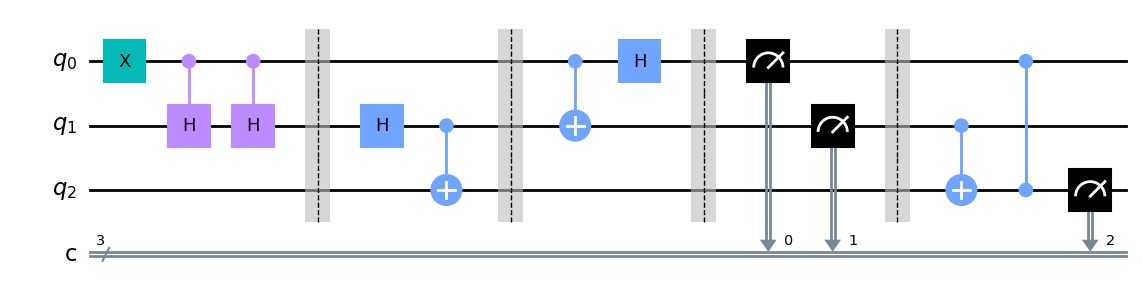

In [10]:
%matplotlib inline
circuit.draw(output='mpl')

Notice that we've added two controlled-Hadamard gates: applying two controlled-Hadamards back to back is equivalent to the identity gate. Theoretically, this is the same circuit, however controlled-Hadamard gates are not supported on the IonQ computer. We will see how we can leverage qBraid's capabilities to still run this circuit on IonQ's computer.

We can observe the supported gate set with the following:

In [12]:
from braket.aws import AwsDevice
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")
# get device name
device_name = device.name
# show supportedQuantumOperations (supported gates for a device)
device_operations = device.properties.dict()['action']['braket.ir.openqasm.program']['supportedOperations']
print('Quantum Gates supported by {}:\\n {}'.format(device_name, device_operations))

Quantum Gates supported by Harmony:\n ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']


We initially programmed this circuit in qiskit, but we want to test braket circuit capabilties on the IonQ computer. Thus, we can use qBraid's circuit wrapper to convert the circuit to braket:

In [13]:
from qbraid import circuit_wrapper

In [14]:
wrapped_circuit = circuit_wrapper(circuit)
braket_circuit = wrapped_circuit.transpile("braket")
print(type(braket_circuit))
print(braket_circuit)

<class 'braket.circuits.circuit.Circuit'>
T  : |0|1|2|3|4|5|6|7|
                      
q0 : -X-C-C-----C-H-C-
        | |     |   | 
q1 : ---H-H-H-C-X-C-|-
              |   | | 
q2 : ---------X---X-Z-

T  : |0|1|2|3|4|5|6|7|


# Attemping to Run the Circuit without qBraid

In [15]:
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")
try:
    job = device.run(braket_circuit, shots=10)
except:
    print("Unsupported gates, circuit cannot be run!")

Unsupported gates, circuit cannot be run!


## Running on an IonQ Device via qBraid

Let's check which devices (specifically IonQ ones) are online, and also find their device IDs:

In [16]:
from qbraid import get_devices

In [17]:
get_devices(filters={"provider": "IonQ"})

Let's check how many credits we have left:

In [18]:
!qbraid jobs get-credits

You have 0.00 remaining qBraid credits.


In this tutorial we'll use IonQ's Harmony computer. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run a job on an IonQ device. The device wrapper adds a layer of abstraction, allowing us to run a braket circuit on an IonQ quantum computer. 

In [19]:
from qbraid import device_wrapper

In [21]:
ionq_device_id = "aws_ionq_harmony" #aws_ionq_harmony is the qBraid ID for the Harmony Computer
device = device_wrapper(ionq_device_id)

Feel free to change the number of shots to reduce the number of qBraid credits:

In [22]:
job = device.run(braket_circuit, shots=50)
job.status() #checking the status of our job

ClientError: An error occurred (400) when calling the CreateQuantumTask operation: Not enough qbraid credits

In [23]:
from qbraid import get_jobs, job_wrapper

In [24]:
get_jobs()

qBraid ID,Submitted,Status
aws_sv_sim-pak225-qjob-97fcatkjdfcxdat5ajar,2023-08-18T18:37:37.676Z,COMPLETED
aws_ionq_harmony-pak225-qjob-o2jap9csrr7kldwfsswn,2023-08-17T07:00:49.884Z,COMPLETED
ibm_q_lima-pak225-qjob-brs3h5n60mwbt65q5mkv,2023-08-17T06:55:16.950Z,COMPLETED
ibm_q_lima-pak225-qjob-bxfu142k4ad7s2ve37mx,2023-08-16T23:28:11.794Z,COMPLETED
aws_ionq_harmony-pak225-qjob-91vedne55b87zssd1qvk,2023-08-16T23:24:24.657Z,COMPLETED
aws_sv_sim-pak225-qjob-xb5tp2utfnkmlelq6pjw,2023-08-16T23:22:25.464Z,COMPLETED
aws_sv_sim-pak225-qjob-sup7vf4xfdis54jfpaap,2023-08-16T22:13:10.976Z,COMPLETED
aws_sv_sim-pak225-qjob-vmf97vqkllxkwftoyksi,2023-08-16T21:53:53.876Z,COMPLETED
aws_sv_sim-pak225-qjob-jviqbvtu4fod1765bu7p,2023-08-16T21:49:40.008Z,COMPLETED
aws_ionq_harmony-pak225-qjob-d1a6fq734y99wbseucob,2023-08-15T07:20:06.653Z,COMPLETED


In [31]:
job = job_wrapper('aws_ionq_harmony-pak225-qjob-91vedne55b87zssd1qvk')

In [26]:
result = job.result()
counts = result.measurement_counts()
print(counts)

{'000': 1, '001': 2, '010': 1, '011': 1, '100': 13, '101': 12, '110': 3, '111': 17}


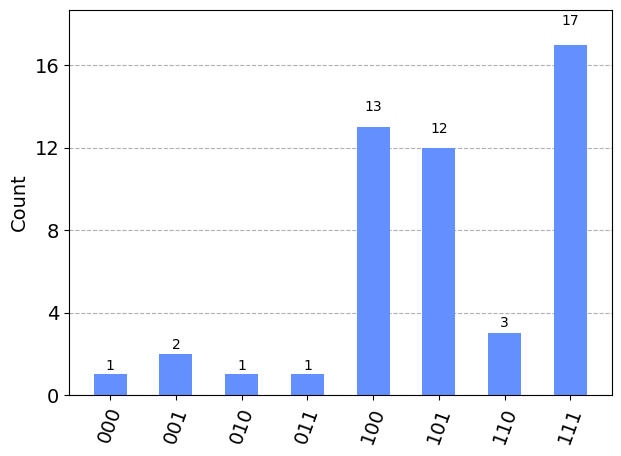

In [27]:
result.plot_counts()

We see that we've correctly teleported the state, since c2 (the leading qubit) is far more likely to be 1, and we teleported the |1> state! Note that for this tutorial we only run 50 shots (and thus observe messy data) due to our credit limit.

We can also run our circuit on a simulator to get cleaner results:

In [30]:
aws_device_id = "aws_sv_sim" #aws_sv_sim is the qBraid id for the SV1 Computer
device = device_wrapper(aws_device_id)
sim_job = device.run(qiskit_circuit, shots=1000)
sim_job.status() #checking the status of our job
result_sim = sim_job.result()
counts_sim = result.measurement_counts()
result_sim.plot_counts()

NameError: name 'qiskit_circuit' is not defined